# Table of Contents/Navigation Links

>Note, if viewed on github this is best viewed using the "Browser Friendly" html document also found in the repository.  The .ipynb file should be downloaded and opened directly in jupyter notebook in order to display correctly and have properly functioning internal links. 

<a href='#intro-anchor'>Introduction</a>

<a href='#initial-anchor'>Initial Material</a>

- <a href='#packages-anchor'>Packages Used</a>

- <a href='#functions-anchor'>Functions Used</a>

- <a href='#init-data-anchor'>Initial Data (post cleaning)</a>

- - <a href='#app1-anchor'>Cleaning Details</a>

<a href='#proc-anchor'>Preliminary Processing</a>

- <a href='#proc-anchor'>Reformatting Genre Column</a>

- <a href='#key-genre-anchor'>Key Genres</a>

<a href='#temp-chap-anchor'>Temporal Factors In Movie Sucesss</a>

- <a href='#temp-chap-anchor'>Exploring general movie success by month</a>

- <a href='#genre-months-anchor'>Plotting Per Month By Genre</a>

- <a href='#ani-spread-anchor'>The Spread In Animation Profits</a>

<a href='#writer-heading-anchor'>Searching For Successful Writers</a>

- <a href='#writer-data-anchor'>Creating Writer Data</a>

- <a href='#top-writer-anchor'>Finding Top Writers</a>

- <a href='#exp-writer-anchor'>Getting Explicit Writer Information</a>

<a href='#conclusion-anchor'>Key Takeaways</a>

- <a href='#disc-anchor'>Discussion \& Results</a>

- <a href='#extension-anchor'>Potential Further Research</a>

<a href='#app1-anchor'>Appendix: Cleaning The Data</a>

- <a href='#app1-anchor'>Importing The Original Anchor</a>

- <a href='#prelim-cleaning-anchor'>Preliminary Cleaning</a>

- <a href='#merge-anchor'>Merging The Data</a>

- <a href='#more-cleaning-anchor'>Further Cleaning</a>

- <a href='#outliers-anchor'>Creating New Columns and Handling Outliers</a>

<a id='intro-anchor'></a>

# Introduction

## Premise

Microsoft seeks to start a movie studio division and seeks recommendations for how to best go about doing this.  It was determined that a wise strategic movie for Microsoft would be to look for decisions that could be made to maximize the likelihood of their first film being reasonably successful; adopting those attributes that would most increase the chances of their first film turning a respectable profit while minimizing risk or uncertainty.  The goal for Microsoft should not necessarily be to be wildly successful out of the park, as a failure in this respect could be quite embarassing, but rather to prove the viability of their new venture. 

## Key Questions:
- Timing: Is there an optimal time to release a film?
- Genre: If film success does seem to have a time-dependent factor, does this continue at a genre-refined level of analysis?
- Provided a genre is determined from the genre+timing analysis, are there key writers to seek out with the genre?

<a id='initial-anchor'></a>

# Initial Material
This must be run prior to executing code cells found later in the notebook.

<a id='packages-anchor'></a>

## Packages Used

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string

<a id='packages-anchor'></a>

## Functions Used

In [6]:
def to_number_from_money(money_string,silent=False):
    """
    Turns values with $XX,XXX format to an integer with XXXXX format.
    An additional parameter, "silent", can be set to 'True' to stop a warning message from printing.

    """
    try:
        money_string=money_string.replace('$','')
        money_string=money_string.replace(',','')
        return(int(money_string))
    except:
        if not silent:
            print('failed, check type or format')
        return(money_string)
    

def formatting(s):
    import string
    """
    Takes a dataframe and a column with dtype = str, and formats it
    to have '_' instead of spaces, and to be lowercase.
    For ease of merging dataframes.
    
    df = dataframe
    column = str of the column name    
    """   
    try:
        #Attempt to capture and eliminate movie titles that end in parenthetical years, e.g. Sunshine (2007)
        if (s[-1] == ')') and (s[-6] == '('):
            s = s[:-6]
    except:
        print(f'error at {s}')
    s = s.strip()
    s = s.translate(str.maketrans('', '', string.punctuation)).replace(' ', '_').lower()

    return s

def cut_outliers(df,series,lower_threshhold=.25,upper_threshhold=.75,multiplier=1.5):
    """
    Mandatory arguments: df, series.  Optional: lower_threshhold, upper_threshhold, multiplier.  Will drop values
    that are greater than a distance of multiplier*(upper_threshhhold-lower_threshhhold) from those threshholds. 
    """
    IQR=(df[series].quantile(upper_threshhold)-df[series].quantile(lower_threshhold))
    return df[df[series].between(df[series].quantile(lower_threshhold)-multiplier*IQR,df[series].quantile(upper_threshhold)+multiplier*IQR)]

def grab_by_element(df,target_column,elem):
    """
    Arguments:  df, target_column, elem
    Returns the dataframe compose of those rows in the original dataframe "df" that have "elem" as an element of their entry
    for column "target_column"
    """
    return df.loc[df[target_column].apply(lambda x: elem in x)]

<a id='init-data-anchor'></a>

## Initial data
Details on how this data was processed and cleaned can be found in <a href='#app1-anchor'>the Appendix</a>

In [7]:
cleaned_data=pd.read_csv('data_for_initial_load.csv')
cleaned_data.head(3)

,movie,production_budget,worldwide_gross,profit_percent,genres,release_year,month,tconst
0,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,154.67,"['Action', 'Adventure', 'Fantasy']",2011,5,tt1298650
1,Dark Phoenix,350000000,149762350,-57.21,"['Action', 'Adventure', 'Sci-Fi']",2019,6,tt6565702
2,Avengers: Age of Ultron,330600000,1403013963,324.38,"['Action', 'Adventure', 'Sci-Fi']",2015,5,tt2395427


A simple dictionary of month names, used in formatting later on:

In [8]:
month_codes={'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

<a id='proc-anchor'></a>

# Preliminary Processing

## Reformatting genre column
In order to use the genre values, we'll have to first adjust the entries in the "genre" column.  The genre entries currently *appear* to be a list, but in actuality are a single string:

In [9]:
print(cleaned_data.genres[0], type(cleaned_data.genres[0]))

['Action', 'Adventure', 'Fantasy'] <class 'str'>


To fix ths, we'll first replace all "null values with the string "No Genre Listed".  We'll then drop the square brackets and split each string at its comma.  A common problem with jupyter notebooks, especially with settings like those we use pandas in where we often find ourselves redefining things repeatedly, is damage coming from running the same cell a second time.  We'll try to mitigate this by first checking that we're applying our rewriting function to a string, and have the function be inert if that's not the case.

In [10]:
cleaned_data.genres=cleaned_data.genres.apply(
    lambda s: s.replace('[','').replace(']','').replace("'",'').replace(' ','').strip().split(',')  # main part of function
    if type(s)==str else s) #type check to try to avoid introducing errors if code is re-ran
type(cleaned_data.genres[0]) #check to make sure type is now list

list

<a id='key-genre-anchor'></a>

## Selecting key genres

Next we'll select those genres that appear more than 95 times in our list of movies to use for analysis, which we'll call
"key_genres".  We'll do this by mapping a function over our "genres" column that takes in values from our list of genres.  We'll feed that back into our list by way of .loc and count how many rows appear.  We'll then filter this result, and run the filter object back into a set.  

In [11]:
movie_genres=set(cleaned_data.genres.sum()) #Combine genre entries, then convert the list into a set.

key_genres=set( 
    filter(lambda g: 
        cleaned_data.loc[cleaned_data.apply( #Select those rows that appear based on the next line
    lambda row: (g in row['genres']),axis=1)].shape[0]>95#Take each row in "movie_genres". Find if it appears more than 95 times
           , movie_genres
    )#End filter
)#Close set
print(key_genres)

{'Animation', 'Action', 'Sci-Fi', 'Biography', 'Drama', 'Comedy', 'Adventure', 'Crime', 'Fantasy', 'Romance', 'Horror', 'Thriller'}


Note that the "appears 95 times" cutoff is somewhat arbitrary, but prevents us from getting genres that appear so few times that the statistical properties of those genres absurd.  For any code that follows, "key_genres" can be replaced with "movie_genres" to see the result of those dropped genres' inclusions.  Individual genres were examined, rather than collections, because it's unclear and questionable the extent to which the combinations, which are user-submitted, are evenly applied to movies.  It seems essentially random, for instance, when a biography does and when it does not get a "history" specification, though a sometimes-present factor is just whether or not other genres "got there first."

The two cells below can be ran to illustrate this.

In [12]:
grab_by_element(cleaned_data,'genres','Biography').sort_values('worldwide_gross').head(3) #Sorting by gross for recognition's sake

,movie,production_budget,worldwide_gross,profit_percent,genres,release_year,month,tconst
759,Love Ranch,25000000,146149,-99.42,"[Biography, Comedy, Drama]",2010,6,tt1125929
1257,The Masked Saint,3500000,182695,-94.78,"[Action, Biography, Crime]",2016,1,tt3103166
1174,The 5th Quarter,6000000,408159,-93.20,"[Biography, Drama, Sport]",2011,3,tt1130964


In [13]:
grab_by_element(
    grab_by_element(cleaned_data,'genres','Biography'),#Running our "grab the biographies" dataframe into the same function
    "genres",'History').sort_values('worldwide_gross').head(3)

,movie,production_budget,worldwide_gross,profit_percent,genres,release_year,month,tconst
847,LBJ,20000000,2507181,-87.46,"[Biography, Drama, History]",2017,11,tt4778988
1072,Testament of Youth,10000000,6646669,-33.53,"[Biography, Drama, History]",2015,6,tt1441953
1077,Churchill,10000000,7582196,-24.18,"[Biography, Drama, History]",2017,6,tt2674454


<a id='temp-chap-anchor'></a>

# Temporal Factors in Movie Success

## Exploring general movie success by month
We wanted to get an idea of when in the year movies tend to do best, assuming there is in fact a clear time when that happens.  Particularly, we want to find a time where movies:
- see a high rate of return on their investment
- see an acceptable level of uncertainty in that rate of return

We first looked across the industry as a whole at how movies did by month.  Here we've taken all movies, grouped them by year, found the average percent profit per month for each year, and then plotted the average percent profit across years by month:

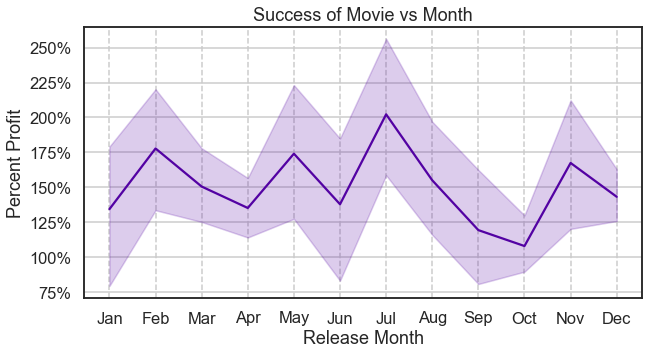

In [14]:
global_context='talk'
fs=1.0
plt.figure(figsize=(10,5))
sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
ax=sns.lineplot(x='month',y='profit_percent',data=cleaned_data.groupby(
['release_year','month']).profit_percent.mean().to_frame().reset_index(),ci=95)
ax.set_xticks(range(1,13))
ax.set_xticklabels([{n:m for m,n in month_codes.items()}[m] for m in range(1,13)])
ax.set(ylabel='Percent Profit')
ax.set(xlabel='Release Month');
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.axes.grid(axis='x',linestyle='--')
ylabels=[f'{int(s)}%' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.xticks(rotation=0)

plt.title('Success of Movie vs Month');

It appears that movies peak in *profitability* in July, which is consistent with the cultural idea of the "summer blockbuster".  We then select July to see how spread out invidual genres perform during the month:

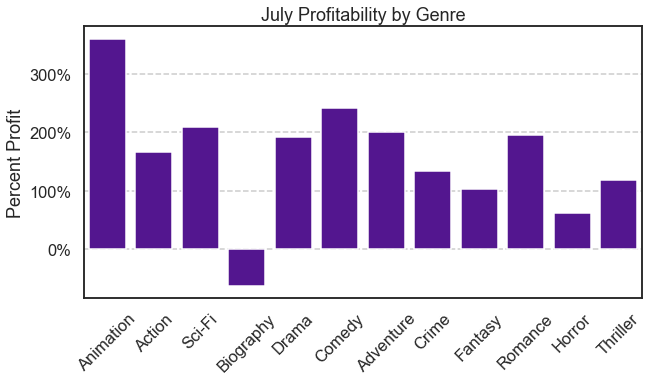

In [15]:
data_for_chart={}
for g in key_genres:
    data_for_chart[g]=grab_by_element(cleaned_data,'genres',g).loc[grab_by_element(cleaned_data,'genres',g).month==7].profit_percent.mean()
  
global_context='talk'
fs=1.0

sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
plt.figure(figsize=(10,5))

ax=sns.barplot(x=list(data_for_chart.keys()),y=list(data_for_chart.values()),color=sns.color_palette('plasma')[0])



ax.set(ylabel='Percent Profit')
ax.set(xlabel='');
ax.xaxis.grid(False)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{int(s)}%' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)

plt.xticks(rotation=45)

plt.title(f'July Profitability by Genre')
plt.show()


<a id='genre-months-anchor'></a>

## Plotting per month by genre

There's a good bit of spread.  As an investigation, we try seeing what each key genre looks like over time.  This is done in essentialy the same way as the overall lineplot, except that we restrict each set to a specific genre using the "grab_by_element" function within a loop over all the key genres.  We repeatedly plot inside the output cell via show(), which then lets us easily scroll though the results-- this lets us look at full-size plots, rather than a grid which would require us to squint at small graphs. We are looking for specific features, not really comparing the graphs to eachother, so this method will be preferable.  Note that we *do* force the vertical axis to run over the same values for each, so that we are not fooled by a change of scale.  Also observe that the fantasy genre has a portion of its graph lacking a confidence interval; this is due to their being a single sample for the relevant time.  

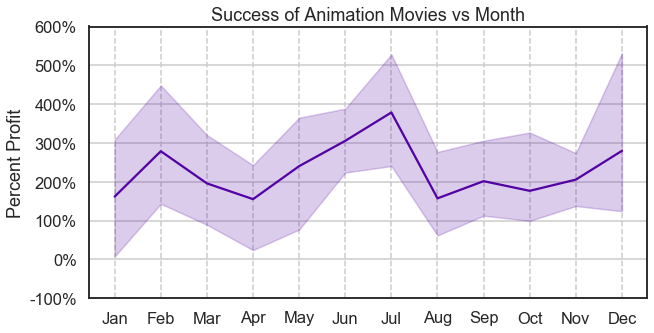

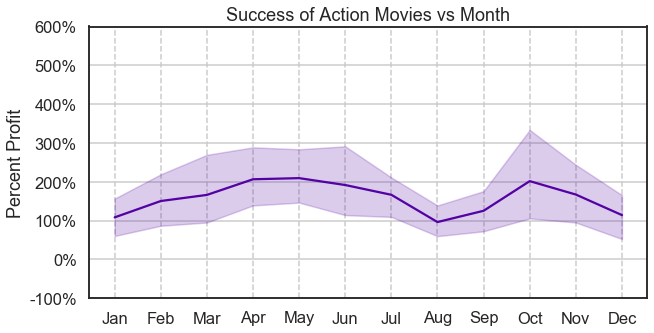

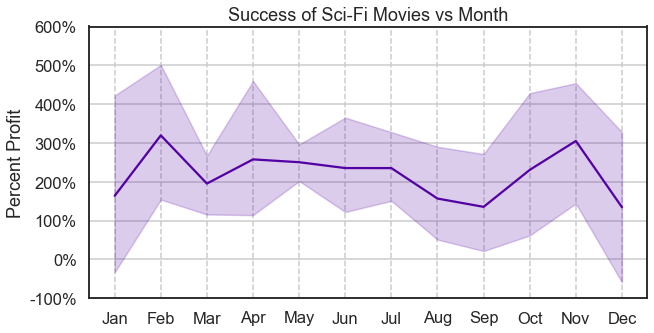

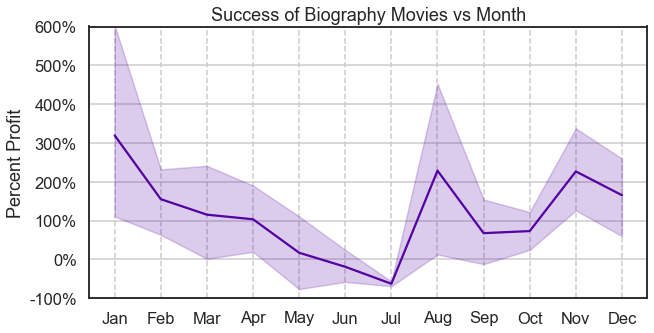

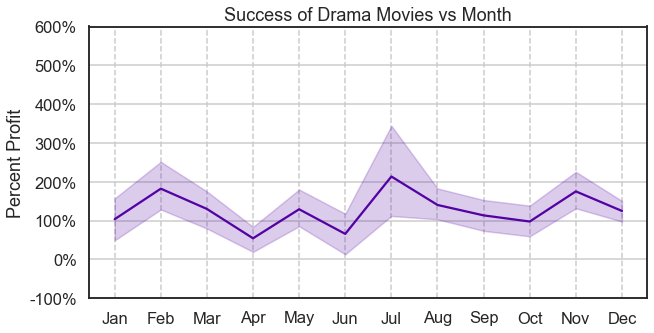

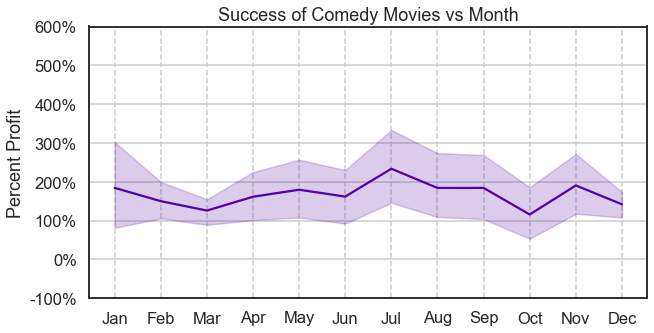

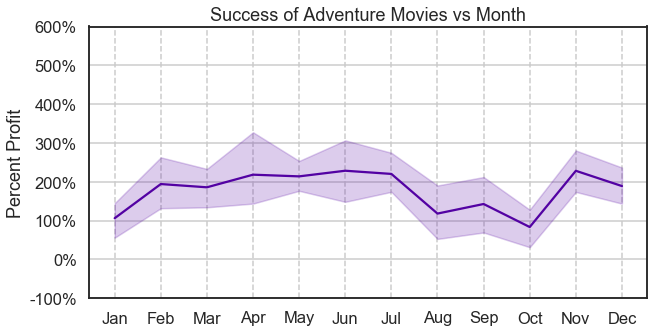

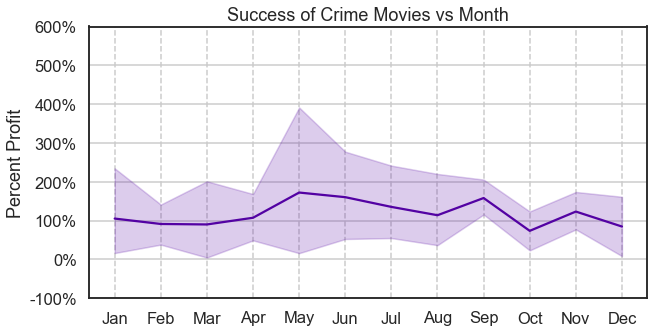

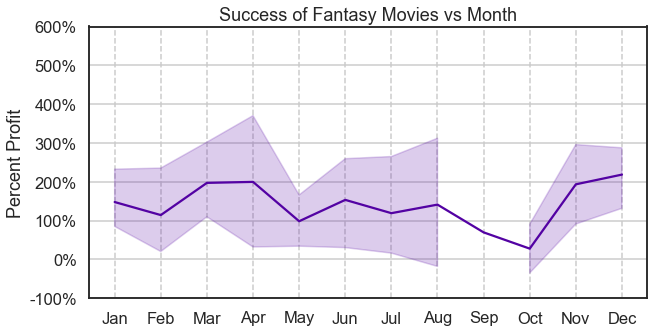

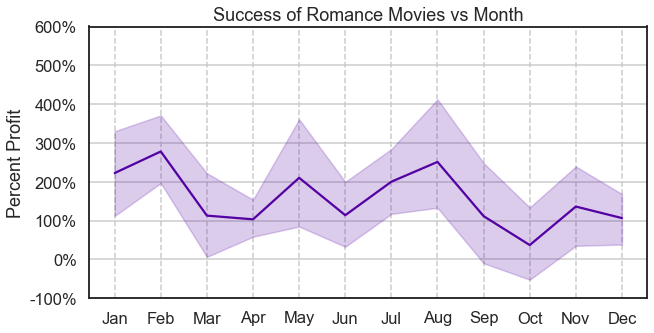

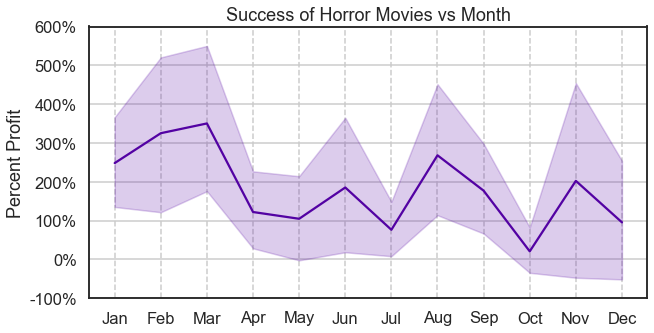

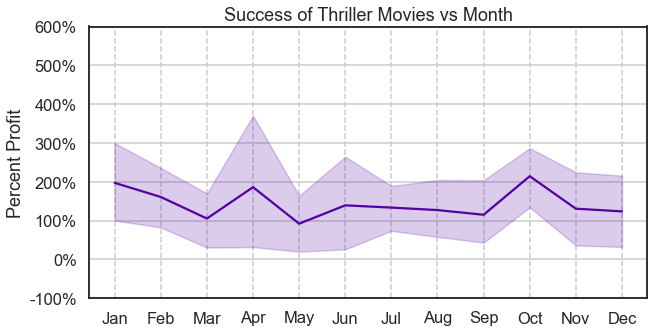

In [16]:
global_context='talk'
fs=1.0

sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
graph_list=[]
for g in key_genres:
    plt.figure(figsize=(10,5))
    plt.ylim(-100,600)
    
    
    ax=sns.lineplot(x='month',y='profit_percent',data=grab_by_element(cleaned_data,'genres',g).groupby(
    ['release_year','month']).profit_percent.mean().to_frame().reset_index(),ci=95)
    ax.set_xticks(range(1,13))

    ax.set_xticklabels([{n:m for m,n in month_codes.items()}[m] for m in range(1,13)])
    ax.set(ylabel='Percent Profit')
    ax.set(xlabel='');
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.axes.grid(axis='x',linestyle='--')
    ylabels=[f'{int(s)}%' for s in ax.get_yticks()]
    ax.set_yticklabels(ylabels)
    
    plt.xticks(rotation=0)

    plt.title(f'Success of {g} Movies vs Month')
    plt.show()


Animated movies seem to have a nice spike in profit around July, where movies can be reliably expected (95% confidence interval off of past observations) to make somewhere between 250% to 550% profit.  This is sensible, as one would expect an increase in the popularity of what are typically child-friendly films during the summer-time.

<a id='ani-spread-anchor'></a>

## The Spread in Animation Profits
Identifying animation as our target, we'll look to see what the spread of the data for animation looks in general:

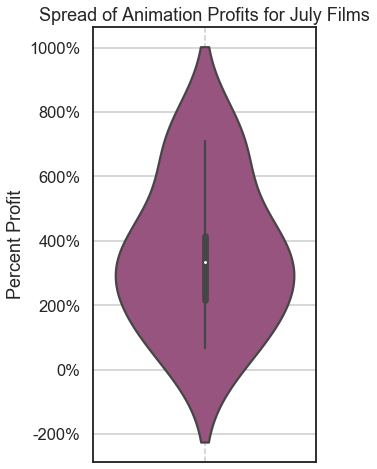

In [17]:
global_context='talk'
fs=1.0
plt.figure(figsize=(4,8))
sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
ax=sns.violinplot(y=grab_by_element(cleaned_data,'genres','Animation').loc[(cleaned_data.month==7)].profit_percent,color=sns.color_palette('plasma')[2],saturation=.5
           )
ax.set(ylabel='Percent Profit');
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.axes.grid(axis='x',linestyle='--')
ylabels=[f'{int(s)}%' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)

plt.xticks(rotation=0)

plt.title('Spread of Animation Profits for July Films')
plt.show()

<a id='writer-heading-anchor'></a>

# Seaching for Sucessful Writers

We now seek out a list of successful writers that can be recruited for an animation project.  We focused on writers for this project under the assumption that they're relatively free to move between studios, can more easily work on multiple projects than many other positions (aiding analysis), and are-- in part due to the job often being less fame-making than directing-- at least as likely, if not more, to sign on to a new project in its early stages.  A strong writer can be paired with a concept team to guide development, which can then help guide the selection of a director.  Directors are not directly sought out in this document, out of concerns for space, however the "job_title" parameter in the first cell below can be changed to "director" and all following cells can be re-ran directly to see the same results for director.

First, we import our data and set the job we are seeking to "writers"

<a id='writer-data-anchor'></a>

## Creating the Writer Data

In [18]:
job_title='writers'

writer_director=pd.DataFrame(pd.read_csv('imdb.title.crew.csv.gz'))
writer_director.head(3)

,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585


We merge this data onto our "cleaned_data" sheet.  We do a left merge, as we're not interested in writers who we will not be able to calculate the efficacy of.

In [19]:
animations=pd.merge(left=grab_by_element(cleaned_data,'genres','Animation'),
                    right=writer_director,left_on="tconst",right_on='tconst',how='left')
animations.head(2)

,movie,production_budget,worldwide_gross,profit_percent,genres,release_year,month,tconst,directors,writers
0,Tangled,260000000,586477240,125.57,"[Adventure, Animation, Comedy]",2010,11,tt0398286,"nm1977355,nm0397174","nm1557594,nm0342278,nm0342303"
1,Incredibles 2,200000000,1242520711,521.26,"[Action, Adventure, Animation]",2018,6,tt3606756,nm0083348,nm0083348


"Writers" comes to us as a string of writers associated with each film, given as imdb ID codes, and separated by commas.  We'll convert this into a proper list using split (using the same type-checking precaution as above), then we'll use "explode" to make a new row, with each row entry containing a single writer from the list for each original row-entry.  For instance, the first row seen above will be replaced with three rows, each identical to the first row except that the writer will be "nm1557594" in the first replacement row, "nm0342278" in the second replacement row, and "nm0342303" in the third. 

Note the use of "job_title" here instead of "writers" directly, keeping the promise made above to the skeptical reader that they can easily see the results for directors should they be so inclined.  

In [20]:
animations[job_title]=animations[job_title].apply(lambda s: s.split(',') if type(s)==str else s)
animations=animations.explode(job_title)
animations.head(4)

,movie,production_budget,worldwide_gross,profit_percent,genres,release_year,month,tconst,directors,writers
0,Tangled,260000000,586477240,125.57,"[Adventure, Animation, Comedy]",2010,11,tt0398286,"nm1977355,nm0397174",nm1557594
0,Tangled,260000000,586477240,125.57,"[Adventure, Animation, Comedy]",2010,11,tt0398286,"nm1977355,nm0397174",nm0342278
0,Tangled,260000000,586477240,125.57,"[Adventure, Animation, Comedy]",2010,11,tt0398286,"nm1977355,nm0397174",nm0342303
1,Incredibles 2,200000000,1242520711,521.26,"[Action, Adventure, Animation]",2018,6,tt3606756,nm0083348,nm0083348


<a id='top-writer-anchor'></a>

## Finding Top Writers
To determine who a strong recommendation for a writer is, we'll seek out the top ten writers that have some measure of experience.  We'll define "experienced" as having been associated with at least 3 animated movies.  

We'll do this by filtering the value counts of writers to those greater than 3,  use that mask on the same value_counts list, then pull the index from that to get our list of writers. 

In [21]:
experienced=animations[job_title].value_counts()[animations[job_title].value_counts()>=3].index 

Next, we can find the mean percent profit for writer and take the top ten entries of that list to get our top ten writers:

In [22]:
member_by_success=animations.loc[
    animations[job_title].apply(lambda x: x in experienced) #Create a mask that checks if the each movie
                                                            #one of our top ten directors
                                ].groupby(job_title).profit_percent.mean().sort_values(ascending=False)
                                                            #For each writer, find their mean percent profit

top_ten=list(member_by_success.index)[:10]
print(top_ten)

['nm1601644', 'nm0567112', 'nm1156984', 'nm1087952', 'nm0520488', 'nm0588087', 'nm0601781', 'nm0714114', 'nm1601882', 'nm0722610']


<a id='exp-writer-anchor'></a>

## Getting Explicit Writer Information
We'll find it useful to have specific information available for each writer, not just a list of IMDB ID codes.  We'll create a nested dictionary for our top ten to help with that.  We'll first import one more dataframe, which matches imdb biographical IDs to actual names.  

We'll then loop through our list of top ten writers, grabbing the relevant info from either our existing "Animations" table or the new table, which we'll call "name_table".

In [85]:
name_table=pd.DataFrame(pd.read_csv('imdb.name.basics.csv.gz')) #Import our new table

namedict={} #Create a blank dictionary
for person in top_ten:
    
    namedict[person]={'name':list(name_table.loc[name_table.nconst==person].primary_name)[0]  #Find the correct entry in name_table
                                                                                              #for our preson, call that "name"                      
                      ,'average_profitability':member_by_success.loc[person], #Recall how member_by_success  was previously defined
                      'known_for':list(animations.loc[animations[job_title]==person].sort_values('profit_percent').movie[:3]
                                      #A nice additional detail to have, this will grab 3 movies the writer has worked on,
                                       #with the list of movies sorted by profitability to assist recognition and "wow"
                                      )}
    
print(namedict[top_ten[0]],'\n') #Show single entry from dictionary as an example
print(list(map(lambda x: namedict[x]['name'], top_ten)))#Show top ten by name

{'name': 'Jennifer Lee', 'average_profitability': 509.6166666666666, 'known_for': ['Wreck-It Ralph', 'Zootopia', 'Frozen']} 

['Jennifer Lee', 'Michael McCullers', 'Kevin Hageman', 'Dan Hageman', 'Phil Lord', 'Christopher Miller', 'Rich Moore', 'Jim Reardon', 'Phil Johnston', 'Don Rhymer']


We'll then investigate the spread of all writers.  We'll make three figures here.  First a violin plot, dark purple, representing the spread of all writers.  Then a second violin plot, this one pink-orange and placed on top, representing the spread of the experienced writers.  Lastly, a swarm plot, placed on top and in pure-orange, representing our top ten writes.

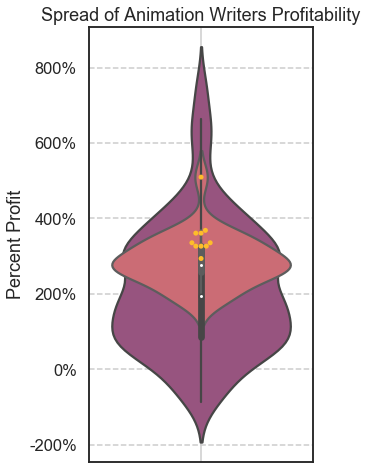

In [60]:
global_context='talk'
fs=1.0
plt.figure(figsize=(4,8))
sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')
ax=sns.violinplot(y=animations.groupby(job_title).profit_percent.mean(),color=sns.color_palette('plasma')[2],saturation=.5)
#Add another violin plot, this time for experienced writers:

ax=sns.violinplot(y=animations.loc[animations[job_title].apply(lambda x: x in experienced)].groupby(job_title).profit_percent.mean(),color=sns.color_palette('plasma')[3])

#Add another plot, this time a swarm plot, representing the top ten writers:

ax=sns.swarmplot(y=animations.loc[animations[job_title].apply(lambda x: x in top_ten)].groupby(job_title).profit_percent.mean(),color=sns.color_palette('plasma')[5])

ax.set(ylabel='Percent Profit');
ax.xaxis.grid(True)
ax.yaxis.grid(True)
ax.axes.grid(axis='y',linestyle='--')
ylabels=[f'{int(s)}%' for s in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.xticks(rotation=0)

plt.title(f'Spread of Animation {job_title.title()} Profitability')
plt.show()

288.6266913580247

We'll also create a simple horizontal bar plot showing the profitability of our top ten writers.  To aid understanding of the relative profitability of the writers shown, we add a vertical line using matplot lib's "axvline" command; recalling again that member_by_success gives a series of the profitability of each of our experienced writers. 

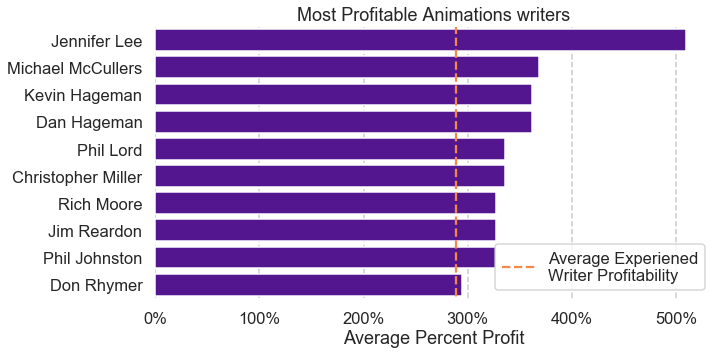

In [81]:
global_context='talk'
fs=1

sns.set(global_context,font_scale=fs)
sns.set_style('white')
sns.set_palette('plasma')

plt.figure(figsize=(10,5))

ax=sns.barplot(y=[namedict[x]['name'] for x in namedict.keys()],x=[namedict[x]['average_profitability'] for x in namedict.keys()],color=sns.color_palette('plasma')[0])

ax.set(xlabel='Average Percent Profit')
ax.set(ylabel='');

sns.despine(left=True,bottom=True)
ax.axes.grid(axis='x',linestyle='--')
xlabels=[f'{int(s)}%' for s in ax.get_xticks()]
ax.set_xticklabels(xlabels)
ax.xaxis.grid(True)
ax.yaxis.grid(False)
plt.xticks(rotation=0)
plt.axvline(member_by_success.mean(), -100,100,c=sns.color_palette('plasma')[-2],ls='--',label='Average Experiened\nWriter Profitability')
plt.legend()
plt.title(f'Most Profitable Animations {job_title}')
plt.show()


***
***

<a id='conclusion-anchor'></a>

# Key Takeaways
- Movie success does vary significantly across time and genre
- An animation movie, released in July, can be expected to see a respectable expected return on profit (250%-500%)
- Within the available list of experienced writers, there are some with a strong track record of success well in excess of average, particularly within the top 4: Jennifer Lee, Michael McCullers, Kevin Hageman, and Dan Hageman.  

<a id='disc-anchor'></a>

## Discussion
The data collected painted a fairly strong set of recommendations for Microsoft to adopt when approaching its first film.  There were some key limitations on the data, however.  Some of these are unavoidable limitations, or limitations that would be difficult to overcome with the resources provided.  Hollywood accounting, for instance, is notoriously opaque and so the reported budget and gross earnings figures are somewhat suspect, being the product of speculation and possibly unreliable numbers and being contingent on whether a whole host of factors (e.g, different marketing tactics) were taken into acocunt.  Many aspects of distribution were difficult to control for.  Some movies, for instance, may see a worldwide full release, with proper marketing and distribution in all markets, while some may see a strong domestic release but a limited international release.  There are some causal assumptions here that may not bear out; particularly it may be that the advantages provided by the timing of a release further incentivize studios to position their already **best** movies to that time slot, and a competitor may have *more* difficulty doing well when competing with those "best" movies than it would add a time of the year when studios position their weaker offerings.  There is a critical choke-point on the data available that must be specifically observed: appearances to the contrary not-withstanding, there are only so many major studio hollywood films put out each year.  Given rapid developments in the film industry, particularly with respect to changing distribution options and international markets as mentioned above, introducing more data by looking further back in time necessarily requires creating a data set that is less representative of the current industry. 

<a id='extension-anchor'></a>

# Topics for Further Research

Many of our limitations could be eliminated or mitigated with further research.  There are methods that could be taken to better control for non-traditional release strategies, including attempting to look for films that have an atypical ratio of domestic income to worldwide income or, within the scope of large studios at least, worldwide income to production budget and then where necessary looking into each film specifically to see what can be gathered.  It may be possible to pull release calendars for randomly chosen, typical branches owned by major theater companies and use the regular presence of suspect films in those calendars to determine which films did get a normal theatrical release.  Quirks in the international market could be partially controlled for by factoring in the number and specifics of the regions the films were released to, data which we already possess, and then perhaps doing the same chain-checking method mentioned above to further the interpretation of the results.  

We could look into how the profitability of a movie within a genre and month relates to the profitability of other movies within that same genre that are released at the same time, perhasp looking to see if there is any obvious relation to box office gross within that genre during that month. 

Looking into writers and directors was regarded as worthwhile under the assumption that it would be relatively easy to obtain a writer or director with a strong track record of success; that's not actually certain however.  It may be that workers with a proven history of performance have specific studios they specifically choose to work with; that the free movement of early cast members is not present in more established ones.  We could investigate how a writer's moving average of profitability relates to the likelihood they'll be working for a different studio in their next film.  

<a id='app1-anchor'></a>

# Appendix: Importing and Cleaning Data

The data above is presented in an already cleaned fashion so as to aid readability by beginning with the "meat" of the project.  Here, we explain the method by which the data set used, "cleaned_data", was obtained. 

## Importing the original data
Two data sets were originally used-- one containing a list of movie titles, genres, and imdb ID codes and one containing a list of movie titles.

In [84]:
budgets = pd.DataFrame(pd.read_csv('tn.movie_budgets.csv.gz'))
budgets.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"


In [87]:
internationals = pd.DataFrame(pd.read_csv('imdb.title.basics.csv.gz'))
internationals.head(2)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"


<a id='prelim-cleaning-anchor'></a>

## Preliminary Cleaning

- We want movies that are representative of those a studio like Microsoft is likely to want to produce.  As truly independent, relatively low budget movies have drastically different concerns and options regarding distribution, marketing, etc we will ignore movies which had a production budget of less than 1 million.  For similar reasons, we'll only consider recent movies-- movies from 2000 and on (which is a nice, clean starting point and lines up with the start of several important trends in film). 
- At this stage, the monetary columns for the "budgets" table are converted to numerical form using the function "to_number"

In [88]:
budgets=budgets.loc[budgets.release_date.apply(lambda x: int(x[-4:])>=2000)]
for col in ['production_budget','domestic_gross','worldwide_gross']:
        budgets[col]=budgets[col].apply(lambda s: to_number_from_money(s,silent=True))
    
budgets=budgets.loc[budgets.production_budget>10**6]

internationals=internationals.loc[internationals.start_year>=2000]

There are several duplicates for movie titles in the "budgets" column, which we'll be trying to use as our main source of data.  Frustratingly, the "budgets" column lacks useful identifying information but does have the gross earnings for the movie, which are crucial.  We'll keep an eye on that for now, the plan will essentially be to use information that should be the same for both, namely the release year, and throw out rows that differ by more than a small amount. Note that this is probably a good idea regardless, as the years differing significantly casts doubt on the integrity of the rest of the data for that entry.  

In [90]:
budgets.loc[budgets.duplicated('movie',keep=False)].sort_values('movie').head(8)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
2140,41,"Dec 4, 2009",Brothers,26000000,28544157,45043870
3307,8,"Aug 14, 2015",Brothers,13000000,656688,17856688
3231,32,"Dec 31, 2008",Ca$h,13700000,0,11738256
4058,59,"Mar 26, 2010",Ca$h,7000000,46488,46488
2463,64,"Apr 16, 2010",Death at a Funeral,21000000,42739347,48977233
2652,53,"Aug 17, 2007",Death at a Funeral,20000000,8580428,46790428
297,98,"Aug 7, 2015",Fantastic Four,120000000,56117548,167849187
484,85,"Jul 8, 2005",Fantastic Four,87500000,154696080,333132750


<a id='merge-anchor'></a>

## Initial Merge
The first data set merge will be between budgets and internationals. We are merging on a 'formatted_title' column that we've created in each to have a common column. 
We'll check for duplicates in 'formatted_title'.  When we do run into duplicates, we'll apply some clever checks to drop as necessary.

In [91]:
budgets['formatted_title'] = budgets.movie.apply(formatting)
budgets.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,avatar
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,pirates_of_the_caribbean_on_stranger_tides


In [93]:
#now to check for duplicates within the 'formatted_title' column
budgets.loc[budgets.duplicated(subset = 'formatted_title',keep=False)].sort_values('movie').head(8)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title
2140,41,"Dec 4, 2009",Brothers,26000000,28544157,45043870,brothers
3307,8,"Aug 14, 2015",Brothers,13000000,656688,17856688,brothers
3231,32,"Dec 31, 2008",Ca$h,13700000,0,11738256,cah
4058,59,"Mar 26, 2010",Ca$h,7000000,46488,46488,cah
2463,64,"Apr 16, 2010",Death at a Funeral,21000000,42739347,48977233,death_at_a_funeral
2652,53,"Aug 17, 2007",Death at a Funeral,20000000,8580428,46790428,death_at_a_funeral
297,98,"Aug 7, 2015",Fantastic Four,120000000,56117548,167849187,fantastic_four
484,85,"Jul 8, 2005",Fantastic Four,87500000,154696080,333132750,fantastic_four


Doing the same for internationals:

In [95]:
internationals['formatted_title'] = internationals.primary_title.apply(formatting)
internationals.head(2)

error at (09)
error at F(t)


,tconst,primary_title,original_title,start_year,runtime_minutes,genres,formatted_title
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",sunghursh
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",one_day_before_the_rainy_season


In [97]:
#Now actually doing the merge:
cleaned_data=pd.merge(left=budgets,right=internationals,how='inner',left_on='formatted_title',right_on='formatted_title',suffixes=('_b','_i'))

Because we're simplifying titles, we should expect to see many false duplications.
We'll do as was mentioned above.  We'll first try to tackle these duplicates, as well as other mis-matches, by dropping anything where the years mis-match too severely.  This is probably indicative of the movies not really being the same, but even if it isn't it's suggestive enough of weirdness in the data that the entry should be viewed as suspect regardless.  Depending on what counts as a "proper" release, you often will see *some* variance in a movie's reported release date; for example if the first festival showing is counted or the first wide release or the first release in a specific market.  We chose a difference of 2 or more years as our cutoff for inclusion in our data set.

In [98]:
#First, we create a release_year column from our release date: 
cleaned_data['release_year']=cleaned_data.release_date.apply(lambda x: int(x[-4:]))

#Now purging values that have the release_year and start_year, which come from our two initial datasets, differ by 2 or more years:

cleaned_data=cleaned_data.drop(cleaned_data.loc[(cleaned_data['release_year'] - cleaned_data['start_year']) ** 2 >= 4].index)

#Notice here we've used the *square* of the differences and the *square* of the cutoff, so as to handle sign issues. 


We'll now check remaining duplicates using the following, which we'll repeatedly invoke:

In [107]:
remaining_duplicates=cleaned_data.loc[cleaned_data.duplicated('formatted_title',keep=False)]
print(f'{remaining_duplicates.shape[0]} left')
remaining_duplicates.head(8)

270 left


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year
27,39,"May 14, 2010",Robin Hood,210000000,105487148,322459006,robin_hood,tt0955308,Robin Hood,Robin Hood,2010,140.0,"Action,Adventure,Drama",2010
34,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt4532826,Robin Hood,Robin Hood,2018,116.0,"Action,Adventure,Thriller",2018
35,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt6858500,Robin Hood,Robin Hood,2018,NaN,NaN,2018
36,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt8558276,Robin Hood,Robin Hood,2017,60.0,"Action,Adventure,History",2018
45,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt1014759,Alice in Wonderland,Alice in Wonderland,2010,108.0,"Adventure,Family,Fantasy",2010
46,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt1926979,Alice in Wonderland,Alice in Wonderland,2011,48.0,Documentary,2010
47,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt2049386,Alice in Wonderland,Alice in Wonderland,2010,99.0,"Fantasy,Musical",2010
98,2,"Nov 22, 2017",Coco,175000000,209726015,798008101,coco,tt10453328,Coco,Coco,2018,NaN,NaN,2017


The remaining duplicates are a little problematic.  For the most part, they don't pose any *major* problems to the integrity of our data; however, given the size of the data-set, each duplicated value will only cause a small distortion for its corresponding month and genre.  Dropping is relatively harmless for the same reason.  Therefore, we'll be a bit aggressive in our strategies for rooting out duplicates, taking any decisions which seem relatively reasonable. First, noticing that our "budgets" sheet is primarily concerned with US films and that Microsoft (being an American company) will be treating the US as a local market, we'll drop any films where the primary title is different from the original title, or where the domestic gross is zero:  

In [101]:
cleaned_data=cleaned_data.drop(index=remaining_duplicates.loc[remaining_duplicates.domestic_gross==0].index)

In [108]:
remaining_duplicates=cleaned_data.loc[cleaned_data.duplicated('formatted_title',keep=False)]
print(f'{remaining_duplicates.shape[0]} left')
remaining_duplicates.head(8)

270 left


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year
27,39,"May 14, 2010",Robin Hood,210000000,105487148,322459006,robin_hood,tt0955308,Robin Hood,Robin Hood,2010,140.0,"Action,Adventure,Drama",2010
34,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt4532826,Robin Hood,Robin Hood,2018,116.0,"Action,Adventure,Thriller",2018
35,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt6858500,Robin Hood,Robin Hood,2018,NaN,NaN,2018
36,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt8558276,Robin Hood,Robin Hood,2017,60.0,"Action,Adventure,History",2018
45,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt1014759,Alice in Wonderland,Alice in Wonderland,2010,108.0,"Adventure,Family,Fantasy",2010
46,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt1926979,Alice in Wonderland,Alice in Wonderland,2011,48.0,Documentary,2010
47,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt2049386,Alice in Wonderland,Alice in Wonderland,2010,99.0,"Fantasy,Musical",2010
98,2,"Nov 22, 2017",Coco,175000000,209726015,798008101,coco,tt10453328,Coco,Coco,2018,NaN,NaN,2017


Following the same reasoning as above, we'll kick out any movies where the primary and original title don't match.  Again, this may kick out some valid movies (eg. the Tom Cruise movie *Edge of Tomorrow* / *Live. Die. Repeat* could potentially fall under this umbrella); however, we can look ahead to make sure that what we're doing seems reasonable, and then choose to move forward only if it's reasonable to suspect that the imperfect improvement in data quality is likely to outweight the not-total detriment. 

In [109]:
cleaned_data=cleaned_data.drop(remaining_duplicates.loc[remaining_duplicates.primary_title!=remaining_duplicates.original_title].index)
remaining_duplicates=cleaned_data.loc[cleaned_data.duplicated('formatted_title',keep=False)]
print(f'{remaining_duplicates.shape[0]} left')
remaining_duplicates.head(8)

233 left


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year
27,39,"May 14, 2010",Robin Hood,210000000,105487148,322459006,robin_hood,tt0955308,Robin Hood,Robin Hood,2010,140.0,"Action,Adventure,Drama",2010
34,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt4532826,Robin Hood,Robin Hood,2018,116.0,"Action,Adventure,Thriller",2018
35,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt6858500,Robin Hood,Robin Hood,2018,NaN,NaN,2018
36,9,"Nov 21, 2018",Robin Hood,99000000,30824628,84747441,robin_hood,tt8558276,Robin Hood,Robin Hood,2017,60.0,"Action,Adventure,History",2018
45,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt1014759,Alice in Wonderland,Alice in Wonderland,2010,108.0,"Adventure,Family,Fantasy",2010
46,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt1926979,Alice in Wonderland,Alice in Wonderland,2011,48.0,Documentary,2010
47,51,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110,alice_in_wonderland,tt2049386,Alice in Wonderland,Alice in Wonderland,2010,99.0,"Fantasy,Musical",2010
98,2,"Nov 22, 2017",Coco,175000000,209726015,798008101,coco,tt10453328,Coco,Coco,2018,NaN,NaN,2017


Still looking for reasons to drop things, we can look for movies where the genre is missing, as those are less useful to us (keeping in mind that we're only doing such operations for duplicated entries):

In [110]:
remaining_duplicates=cleaned_data.loc[cleaned_data.duplicated('formatted_title',keep=False)]
cleaned_data=cleaned_data.drop(remaining_duplicates.loc[remaining_duplicates.genres.isna()].index)

We'll now take the more aggressive strategy of just dropping duplicates.  To try to mitigate this, we'll consider only duplicates where both the title is repeated and where the production budget has been "used twice."

In [111]:
cleaned_data=cleaned_data.drop(cleaned_data.loc[cleaned_data.duplicated(['formatted_title','production_budget'])].index)

<a id='more-cleaning-anchor'></a>

## Further Cleaning

Many of the films for which both domestic and woldwide gross are both zero are films where either the data appears to be missing due to not being entered, or appears to be missing because of no easily obtainable/assignable gross earnings, e.g. the netflix film 'Bright'.  As such, these values will be dropped.

In [113]:
cleaned_data.loc[(cleaned_data['domestic_gross'] == 0) & (cleaned_data['worldwide_gross'] ==0)].head(4)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year
409,80,"Dec 13, 2017",Bright,90000000,0,0,bright,tt5519340,Bright,Bright,2017,117.0,"Action,Crime,Fantasy",2017
434,36,"Feb 21, 2020",Call of the Wild,82000000,0,0,call_of_the_wild,tt7504726,Call of the Wild,Call of the Wild,2020,NaN,"Adventure,Animation,Family",2020
630,52,"Dec 11, 2015",The Ridiculous 6,60000000,0,0,the_ridiculous_6,tt2479478,The Ridiculous 6,The Ridiculous 6,2015,119.0,"Comedy,Western",2015
632,53,"Nov 8, 2019",Midway,59500000,0,0,midway,tt6924650,Midway,Midway,2019,NaN,"Action,Drama,History",2019


In [114]:
#dropping the 89 aforementioned rows
cleaned_data=cleaned_data.drop(cleaned_data.loc[(cleaned_data['domestic_gross'] == 0) & (cleaned_data['worldwide_gross'] ==0)].index)

As a part of our aggressive cleaning strategy, we will delete movies where the domestic gross is zero, and the worldwide gross is greater than zero.This is indicative of movies with either a data collection issue, a solely foreign release, or a non-traditional distribution strategy. We do this as a separate step to call attention to it, as the rationale is a little different.  

In [117]:
cleaned_data=cleaned_data.drop(cleaned_data.loc[(cleaned_data['domestic_gross'] == 0) & (cleaned_data['worldwide_gross'] != 0)].index)

<a id='outliers-anchor'></a>

## Adding new columns and dropping outliers

We'll add a vitally important table now, which gives the month each movie was released.

In [119]:
cleaned_data['month']=cleaned_data.release_date.apply(lambda s: month_codes[s.replace(',','').split()[0]])
cleaned_data.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year,month
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,pirates_of_the_caribbean_on_stranger_tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2011,5
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,dark_phoenix,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",2019,6


 Now we will add columns for our rate  percent profit. 

In [120]:
cleaned_data['profit_percent'] = round(((cleaned_data.worldwide_gross - cleaned_data.production_budget)/ cleaned_data.production_budget) * 100, 2)
cleaned_data.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year,month,profit_percent
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,pirates_of_the_caribbean_on_stranger_tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2011,5,154.67
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,dark_phoenix,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",2019,6,-57.21


 Movies on rare occasions will do *extremely* well or *extremely* poorly out of what is partially just luck.  Consider the Blair Witch project, which brought back found footage film after its singularly successful use prior, by  Cannibal Holocaust in 1980 and which went on to make hundreds of millions on a budget of hundreds of thousands, or on the other end a film like  Zoolander, a well-loved comedy but which had the misfortune to be released just a few weeks after 9/11.  

 We'll thus trim the outliers.  It doesn't seem reasonably to assume normality in our data, so we'll follow the conventional approach of dropping outliers that fall outside of a 1.5-factor distance from our interquartile range.  We still see quite a spread of percent profits even with these outliers dropped, in an absolute sense running from around 0.3% to 760%

In [121]:
cleaned_data=cut_outliers(cleaned_data,'profit_percent',multiplier=1.5)
cleaned_data.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,formatted_title,tconst,primary_title,original_title,start_year,runtime_minutes,genres,release_year,month,profit_percent
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,pirates_of_the_caribbean_on_stranger_tides,tt1298650,Pirates of the Caribbean: On Stranger Tides,Pirates of the Caribbean: On Stranger Tides,2011,136.0,"Action,Adventure,Fantasy",2011,5,154.67
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,dark_phoenix,tt6565702,Dark Phoenix,Dark Phoenix,2019,113.0,"Action,Adventure,Sci-Fi",2019,6,-57.21


All that remains now is to drop the columns that we won't actually use, to help with readability.  This in actuality was done after the fact, as there's only marginal benefit to doing so in the form of not having to scroll horizontally. The code used is given below, though it will need to be preceded with "cleaned_data=" to actually take effect.  The resulting data set was then exported using 

``cleaned_data.('file_name.csv',index=False)``

In [122]:
cleaned_data[['movie','production_budget','worldwide_gross','profit_percent','genres','release_year','month','tconst']]

,movie,production_budget,worldwide_gross,profit_percent,genres,release_year,month,tconst
1,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,154.67,"Action,Adventure,Fantasy",2011,5,tt1298650
2,Dark Phoenix,350000000,149762350,-57.21,"Action,Adventure,Sci-Fi",2019,6,tt6565702
3,Avengers: Age of Ultron,330600000,1403013963,324.38,"Action,Adventure,Sci-Fi",2015,5,tt2395427
4,Avengers: Infinity War,300000000,2048134200,582.71,"Action,Adventure,Sci-Fi",2018,4,tt4154756
5,Justice League,300000000,655945209,118.65,"Action,Adventure,Fantasy",2017,11,tt0974015
...,...,...,...,...,...,...,...,...
3068,Filly Brown,1250000,2940411,135.23,"Drama,Music",2013,4,tt1869425
3072,Home Run,1200000,2859955,138.33,"Drama,Sport",2013,4,tt2051894
3073,Blue Like Jazz,1200000,595018,-50.42,"Comedy,Drama",2012,4,tt1758575
3074,"Pink Ribbons, Inc.",1200000,26608,-97.78,Documentary,2012,6,tt2035599
